# Exploration of TMDB/movielens data

In [33]:
import numpy as np
from numpy import dot
from numpy.linalg import norm
import pickle
import pandas as pd
from tqdm import tqdm
tqdm.pandas()

from sentence_transformers import SentenceTransformer
sentence_bert = SentenceTransformer('paraphrase-MiniLM-L6-v2')

# https://arxiv.org/pdf/1803.11175.pdf
# https://tfhub.dev/google/universal-sentence-encoder/4
import tensorflow as tf
import tensorflow_hub as hub
universal_sentence_encoder = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")

def cosine_similarity(v1, v2):
    return dot(v1, v2)/(norm(v1)*norm(v2))

In [34]:
def calculate_embedding(sentence, use_sbert=True):
    if use_sbert:
        return sentence_bert.encode(sentence)
    else:
        return universal_sentence_encoder([sentence])

with open('enriched_movies.pickle', 'rb') as handle:
    df = pickle.load(handle)
    df["embedding"] = df.apply(lambda d : calculate_embedding(d["overview"]), axis=1)


In [36]:
df.head()

,title_tmdb,genres_tmdb,overview,popularity,release_date,title_movielens,genres_movielens,embedding
1,Toy Story,"[Animation, Adventure, Family, Comedy]","Led by Woody, Andy's toys live happily in his ...",158.217,1995-10-30,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,"[0.025404971, -0.09251755, 0.27215254, -0.2384..."
2,Jumanji,"[Adventure, Fantasy, Family]",When siblings Judy and Peter discover an encha...,15.216,1995-12-15,Jumanji (1995),Adventure|Children|Fantasy,"[0.25047928, 0.0082574645, -0.018063335, -0.40..."
3,Grumpier Old Men,"[Romance, Comedy]",A family wedding reignites the ancient feud be...,10.227,1995-12-22,Grumpier Old Men (1995),Comedy|Romance,"[-0.18674998, 0.3785867, 0.19608602, -0.113897..."
4,Waiting to Exhale,"[Comedy, Drama, Romance]","Cheated on, mistreated and stepped on, the wom...",8.735,1995-12-22,Waiting to Exhale (1995),Comedy|Drama|Romance,"[0.15951346, 0.036610216, 0.15571721, 0.202204..."
5,Father of the Bride Part II,"[Comedy, Family]",Just when George Banks has recovered from his ...,15.675,1995-12-08,Father of the Bride Part II (1995),Comedy,"[0.02012879, 0.24973528, 0.028397255, -0.07890..."


In [37]:
df_sim = df[["title_tmdb", "embedding"]]
df_sim = df_sim.merge(df_sim, how="cross")
df_sim["pair"] = df_sim.progress_apply(lambda r : " - ".join(sorted([r["title_tmdb_x"], r["title_tmdb_y"]])),axis=1)
df_sim = df_sim[df_sim["title_tmdb_x"] != df_sim["title_tmdb_y"]]
df_sim.drop_duplicates(subset=["pair"], inplace=True)
df_sim.head()

100%|██████████| 100/100 [00:00<00:00, 27138.82it/s]


,title_tmdb_x,embedding_x,title_tmdb_y,embedding_y,pair
1,Toy Story,"[0.025404971, -0.09251755, 0.27215254, -0.2384...",Jumanji,"[0.25047928, 0.0082574645, -0.018063335, -0.40...",Jumanji - Toy Story
2,Toy Story,"[0.025404971, -0.09251755, 0.27215254, -0.2384...",Grumpier Old Men,"[-0.18674998, 0.3785867, 0.19608602, -0.113897...",Grumpier Old Men - Toy Story
3,Toy Story,"[0.025404971, -0.09251755, 0.27215254, -0.2384...",Waiting to Exhale,"[0.15951346, 0.036610216, 0.15571721, 0.202204...",Toy Story - Waiting to Exhale
4,Toy Story,"[0.025404971, -0.09251755, 0.27215254, -0.2384...",Father of the Bride Part II,"[0.02012879, 0.24973528, 0.028397255, -0.07890...",Father of the Bride Part II - Toy Story
5,Toy Story,"[0.025404971, -0.09251755, 0.27215254, -0.2384...",Heat,"[0.03366178, -0.23658101, -0.5412233, -0.20487...",Heat - Toy Story


In [38]:
df_sim["distance"] = df_sim.apply(lambda x: 1.0 - cosine_similarity(x["embedding_x"], x["embedding_y"]), axis=1)
df_sim.head()

,title_tmdb_x,embedding_x,title_tmdb_y,embedding_y,pair,distance
1,Toy Story,"[0.025404971, -0.09251755, 0.27215254, -0.2384...",Jumanji,"[0.25047928, 0.0082574645, -0.018063335, -0.40...",Jumanji - Toy Story,0.586807
2,Toy Story,"[0.025404971, -0.09251755, 0.27215254, -0.2384...",Grumpier Old Men,"[-0.18674998, 0.3785867, 0.19608602, -0.113897...",Grumpier Old Men - Toy Story,0.832464
3,Toy Story,"[0.025404971, -0.09251755, 0.27215254, -0.2384...",Waiting to Exhale,"[0.15951346, 0.036610216, 0.15571721, 0.202204...",Toy Story - Waiting to Exhale,0.871367
4,Toy Story,"[0.025404971, -0.09251755, 0.27215254, -0.2384...",Father of the Bride Part II,"[0.02012879, 0.24973528, 0.028397255, -0.07890...",Father of the Bride Part II - Toy Story,0.794465
5,Toy Story,"[0.025404971, -0.09251755, 0.27215254, -0.2384...",Heat,"[0.03366178, -0.23658101, -0.5412233, -0.20487...",Heat - Toy Story,0.845682


/Users/pilillo/opt/miniconda3/envs/recsys/lib/python3.10/site-packages/seaborn/matrix.py:624: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method=self.method,


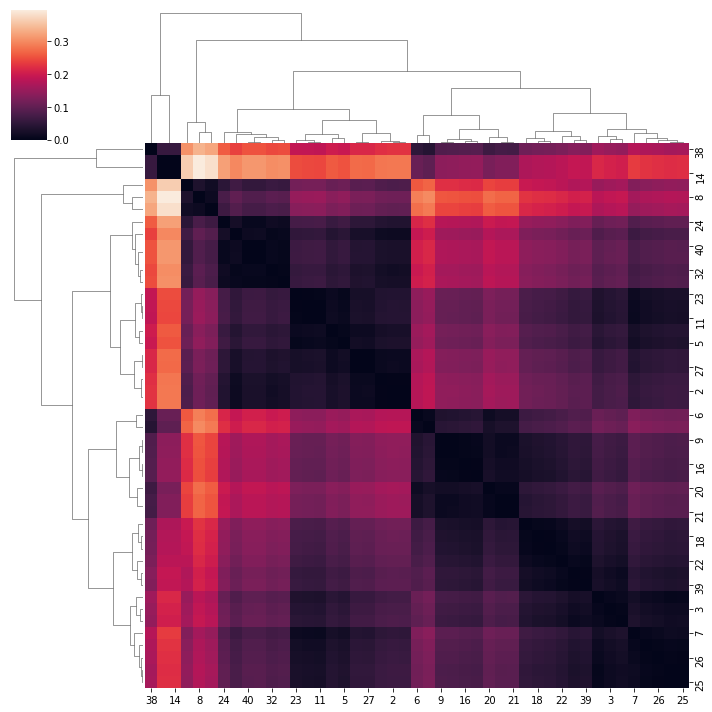

In [39]:
from sklearn.metrics import pairwise_distances
import seaborn as sns


distances = pairwise_distances(X=df_sim["distance"].values.reshape(-1, 1))
#sns.heatmap(distances, square=True, annot=True, cbar=False, cmap='Blues')
sns.clustermap(distances)#,  cmap='Blues')
